In [292]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import re

import xarray as xr
# import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import gsw

In [293]:
## Read in and Process Cruise Track

nav_raw = pd.read_csv("../data/hourly_nav_raw.txt", header=None).iloc[:, [0, 2, 3, 4, 5]]
# lon data in degree minutes, need to split the column and convert back to decimal degrees
# need to make lon data negative to reflect W

cruise_track = pd.DataFrame()

cruise_track['lon'] = nav_raw[4].transform(lambda x: x/100).astype('str').str.split('.')
cruise_track['lon_deg'] = pd.to_numeric(cruise_track['lon'].str.get(0))
cruise_track['lon_min'] = pd.to_numeric(cruise_track['lon'].str.get(1).str[:6]).transform(lambda x: (x/10000)/60)
cruise_track['lon'] = cruise_track['lon_deg'] + cruise_track['lon_min']
cruise_track['lon'] = cruise_track['lon'].transform(lambda x: x * -1)

# lat data also needs to be reformatted, but dont need to make it negative
cruise_track['lat'] = nav_raw[2].transform(lambda x: x/100)
cruise_track['lat'] = nav_raw[2].transform(lambda x: x/100).astype('str').str.split('.')
cruise_track['lat_deg'] = pd.to_numeric(cruise_track['lat'].str.get(0))
cruise_track['lat_min'] = pd.to_numeric(cruise_track['lat'].str.get(1).str[:6]).transform(lambda x: (x/10000)/60)
cruise_track['lat'] = cruise_track['lat_deg'] + cruise_track['lat_min']

In [294]:
## Read in Station Data

stations = pd.read_table('../data/ctd_stations_SKQ202310S_ToTS.txt') # this was the original method

# stations = pd.read_csv('../results/stations_withSedChl.csv')
stations

,StationCast,Section Name,Lat,Lon,Date,Time,Bottom Depth
0,S001C01,BS1,65.6193,-168.150,20230617,744,26
1,S002C01,BS2,65.6483,-168.272,20230617,857,26
2,S003C01,BS3,65.6733,-168.370,20230617,957,51
3,S004C01,BS4,65.6942,-168.463,20230617,1059,54
4,S005C01,BS5,65.7160,-168.559,20230617,1200,52
...,...,...,...,...,...,...,...
299,S296C01,DBO2-9,64.6723,-167.781,20230729,907,35
300,S297C01,DBO2-10,64.6713,-167.464,20230729,1017,28
301,S298C01,DBO2-11,64.6728,-167.150,20230729,1125,29
302,S299C01,DBO2-12,64.6728,-166.835,20230729,1235,25


In [295]:
station_ice = pd.read_csv('../../data_general/data_station_meta/observed_ice_edge_bridgecam_updated072425.csv')
station_ice

,station,ice_obs
0,1,ow
1,2,ow
2,3,miz
3,4,miz
4,5,miz
...,...,...
295,296,ow
296,297,ow
297,298,ow
298,299,ow


In [296]:
## pull in flux data
# trap_flux_data = pd.read_csv('../results/trap_flux_by_lap.csv')
# trap_flux_data['iceTethered'].astype(bool)
# trap_flux_data

trap_flux_data = pd.read_csv('../data/trap_flux_by_lap.csv')
trap_flux_data = pd.merge(trap_flux_data, station_ice, left_on='deployStation', right_on='station', how='left')
trap_flux_data['ice_class'] = trap_flux_data['ice_obs']
trap_flux_data.drop(columns=['station', 'ice_obs'], inplace=True)
trap_flux_data

,deployment,iceTethered,deployStation,recoverStation,deployLap,recoverLap,shallowSampleNumber,deepSampleNumber,shallowTrapDepth,deepTrapDepth,shallowFlux,deepFlux,ice_class
0,T002,False,16,24,1,1.0,T002S,T002D,15,30,6.518350,5.461499,miz
1,T003,True,21,40,1,2.0,T003S,T003D,3,29,2.273107,0.367069,ice
2,T004,False,26,47,1,2.0,T004S,T004D,15,25,0.242644,0.651770,ow
3,T005,False,29,52,1,2.0,T005S,T005D,15,30,7.851471,7.233234,miz
4,T006,True,32,53,1,2.0,T006S,T006D,1,35,0.415166,2.372698,ice
5,T007,True,38,57,2,2.0,T007S,T007D,1,30,3.740341,0.540463,ice
6,T008,True,42,78,2,3.0,T008S,T008D,1,30,5.232519,1.468744,ice
7,T009,False,45,75,2,3.0,T009S,T009D,15,35,4.607082,3.980240,miz
8,T010,False,48,73,2,3.0,T010S,T010D,15,25,0.078346,0.565547,ow
9,T011,True,61,83,2,3.0,T011S,T011D,1,30,0.555657,0.127278,ice


In [297]:

def append_vars_from_trap_flux_data(list_of_varNames, trapInteger, outputDataframe):
    for varName in list_of_varNames:
        outputDataframe[varName] = trap_flux_data[trap_flux_data['deployment']==str('T'+f'{trapInteger:03}')][varName].values[0]


In [298]:
print('T010 Deployment Lap Must be Hardcoded because data is from different spreadsheet')
print('T010 Deployment Lap =', trap_flux_data[trap_flux_data['deployment']==str('T010')]['deployLap'].values[0])

T010 Deployment Lap Must be Hardcoded because data is from different spreadsheet
T010 Deployment Lap = 2


This next code chunk actually reads in the data

In [299]:
list_of_vars = ['deployLap', 'recoverLap', 'iceTethered', 'shallowTrapDepth', 'deepTrapDepth', 'ice_class'] #, 'shallowFlux', 'deepFlux']

full_deployments = []
recovery_locations = []
for i in range(1, 30):
    if i == 1:
        print('loop'+ f'{i:02}: T001 was a Test Deployment. Track not included.')
    elif i == 10:
        print('loop'+ f'{i:02}: T010 read in separately beacuse track is from Spotter Beacon')
        t010_beaconLost = pd.read_csv('../data/full_deployments/T010_full_deployment_beaconLoss.csv')
        t010_spotter = pd.read_csv('../data/full_deployments/T010_full_deployment_spotter.csv')
        append_vars_from_trap_flux_data(list_of_vars, 10, t010_spotter)
    elif i == 21:
        print('loop'+ f'{i:02}: T021 read in separately beacuse trap line was lost before recovery')
        t021_beaconPath = pd.read_csv('../data/full_deployments/T021_full_deployment_beacon.csv')
        t021_beaconPath.rename(columns={'Asset Name':'assetName',
                                        'Data Date (AKDT)':'dateTimeAKDT',
                                        ' Latitude':'latitude',
                                        ' Longitude':'longitude'}, inplace=True)
        t021_trapLine = pd.read_csv('../data/full_deployments/T021_full_deployment_trapline.csv')
        t021_trapLine.rename(columns={'Asset Name':'assetName',
                                      'Data Date (AKDT)':'dateTimeAKDT',
                                      ' Latitude':'latitude',
                                      ' Longitude':'longitude'}, inplace=True)
        t021_spotter = pd.read_csv('../data/full_deployments/T021_full_deployment_spotter.csv')
        t021_spotter['time'] = t021_spotter['Epoch Time'].transform(lambda x: dt.fromtimestamp(x)) # epoch time is in AKDT it seems
        t021_spotter = t021_spotter[t021_spotter['time'] >= dt.strptime('2023-07-13 09:48:00', "%Y-%m-%d %H:%M:%S")] # no time points before deploy
        t021_spotter = t021_spotter[t021_spotter['time'] <= dt.strptime('2023-07-17 09:30:00', "%Y-%m-%d %H:%M:%S")] # no time points after recover
    else:
        try:
            df = pd.read_csv('../data/full_deployments/T'+ f'{i:03}' +'_full_deployment.csv')
            df['trapNum'] = str('T' + f'{i:03}')
            append_vars_from_trap_flux_data(list_of_vars, i, df)
            df.rename(columns={'Asset Name':'assetName',
                                'Data Date (AKDT)':'dateTimeAKDT',
                                ' Latitude':'latitude',
                                ' Longitude':'longitude'}, inplace=True)
            full_deployments.append(df)
                            
            recovery_locations.append(pd.DataFrame({'deployment':['T00'+str(i)],
                                                'final_lat':df['latitude'][0],
                                                'final_lon':df['longitude'][0]}))

        
            print('loop'+ f'{i:02}: ' + df['trapNum'].iloc[0] + ' read in successfully')
        except FileNotFoundError:
            print('loop'+ f'{i:02}: T'+ f'{i:03}_full_deployment.csv not Found' )
        except:
            print('Something Else Went Wrong')

loop01: T001 was a Test Deployment. Track not included.
loop02: T002 read in successfully
loop03: T003 read in successfully
loop04: T004 read in successfully
loop05: T005 read in successfully
loop06: T006 read in successfully
loop07: T007 read in successfully
loop08: T008 read in successfully
loop09: T009 read in successfully
loop10: T010 read in separately beacuse track is from Spotter Beacon
loop11: T011 read in successfully
loop12: T012 read in successfully
loop13: T013 read in successfully
loop14: T014 read in successfully
loop15: T015 read in successfully
loop16: T016 read in successfully
loop17: T017 read in successfully
loop18: T018 read in successfully
loop19: T019 read in successfully
loop20: T020 read in successfully
loop21: T021 read in separately beacuse trap line was lost before recovery
loop22: T022 read in successfully
loop23: T023 read in successfully
loop24: T024 read in successfully
loop25: T025 read in successfully
loop26: T026 read in successfully
loop27: T027 read 

In [300]:
full_deployments[0].columns

Index(['assetName', 'Asset Id', 'dateTimeAKDT', 'latitude', 'longitude',
       ' Speed', ' SATNUM', ' HDOP', ' GPS Accuracy', ' Time To First Fix',
       ' Battery Voltage', ' Temperature', ' Event', ' Report Body', 'trapNum',
       'deployLap', 'recoverLap', 'iceTethered', 'shallowTrapDepth',
       'deepTrapDepth', 'ice_class'],
      dtype='object')

In [301]:
dist_traveled = []
for deployment in full_deployments:
    print(deployment['trapNum'][0])
    # print(deployment['latitude'].iloc[0])
    # print(deployment['latitude'].iloc[-1])
    distance = gsw.geostrophy.distance([deployment['longitude'].iloc[0], deployment['longitude'].iloc[-1]],
                                       [deployment['latitude'].iloc[0], deployment['latitude'].iloc[-1]])/1000 # in KM
    dist_traveled.append(distance)
    print(distance)
    

T002
[11.84861125]
T003
[19.54280379]
T004
[24.75674791]
T005
[102.69892518]
T006
[48.98082579]
T007
[55.73359614]
T008
[71.37507266]
T009
[89.05565953]
T011
[33.69714723]
T012
[49.59911221]
T013
[82.52213709]
T014
[39.99036735]
T015
[68.9428972]
T016
[49.73271553]
T017
[26.22241556]
T018
[24.19484872]
T019
[35.64485711]
T020
[44.1707671]
T022
[nan]
T023
[16.34075484]
T024
[61.4324864]
T025
[54.36470022]
T026
[23.74141193]
T027
[16.2041971]
T028
[66.33699712]
T029
[36.28973439]


In [302]:
np.nanmean(dist_traveled), np.nanstd(dist_traveled)

(46.13679157488257, 23.886318445538816)

In [303]:
max_tf = np.max([np.max(trap_flux_data['shallowFlux']), np.max(trap_flux_data['deepFlux'])])
min_tf = np.min([np.min(trap_flux_data['shallowFlux']), np.min(trap_flux_data['deepFlux'])])

print(max_tf, min_tf)

7.851471441 0.017923188


In [304]:
# Read in Bathy Data

bathy_data = xr.open_dataset('../data/bathymetry_data/ETOPO2v2c_f4.nc')

bathy_data

<xarray.Dataset>
Dimensions:  (x: 10800, y: 5400)
Coordinates:
  * x        (x) float32 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 179.9 180.0
  * y        (y) float32 -89.98 -89.95 -89.92 -89.88 ... 89.88 89.92 89.95 89.98
Data variables:
    z        (y, x) float32 ...
Attributes:
    Conventions:  COARDS
    title:        
    source:                               -Rd -I2m -ZTLf                     ...
    node_offset:  1

In [305]:
# extent = [-175, -150, 55, 75]

# Define the extent of the region you want to trim to
# Lon is special, need -180 to -150 and 150 to 180
lat_min, lat_max = 55, 85

# Trim the dataset to the specified extent
selected_bathy = bathy_data.sel(x=slice(-180, -140), y=slice(lat_min, lat_max)) # Select lats 40 to 90
# selected_bathy2 = bathy_data.sel(x=slice(165, 180), y=slice(lat_min, lat_max)) # Select lats 40 to 90
# selected_bathy = xr.concat([selected_bathy, selected_bathy2], dim='x')

bathy_context = selected_bathy.where(selected_bathy['z'] < 0, drop=True)
bathy_context['z'] = bathy_context['z'] * -1 # make the values positive
bathy_context

<xarray.Dataset>
Dimensions:  (y: 900, x: 1200)
Coordinates:
  * x        (x) float32 -180.0 -179.9 -179.9 -179.9 ... -140.1 -140.1 -140.0
  * y        (y) float32 55.02 55.05 55.08 55.12 ... 84.88 84.92 84.95 84.98
Data variables:
    z        (y, x) float32 3.787e+03 3.795e+03 ... 2.117e+03 2.115e+03
Attributes:
    Conventions:  COARDS
    title:        
    source:                               -Rd -I2m -ZTLf                     ...
    node_offset:  1

In [306]:
# lon_min, lon_max = -170, -155
# lat_min, lat_max = 65, 75

lon_min, lon_max = -180, 180
lat_min, lat_max = 55, 75

bathy = bathy_context.sel(x=slice(lon_min, lon_max), y=slice(lat_min, lat_max))
bathy = bathy.where(bathy['z'] < 150, drop = True)


/Users/jameslauer/miniconda3/envs/genericOcean/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jameslauer/miniconda3/envs/genericOcean/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jameslauer/miniconda3/envs/genericOcean/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jameslauer/miniconda3/envs/genericOcean/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jameslauer/miniconda3/envs/genericOcean/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jameslauer/miniconda3/envs/genericOcean/lib/python3.11/site-packages/shapely/constructive.py:181: Runti

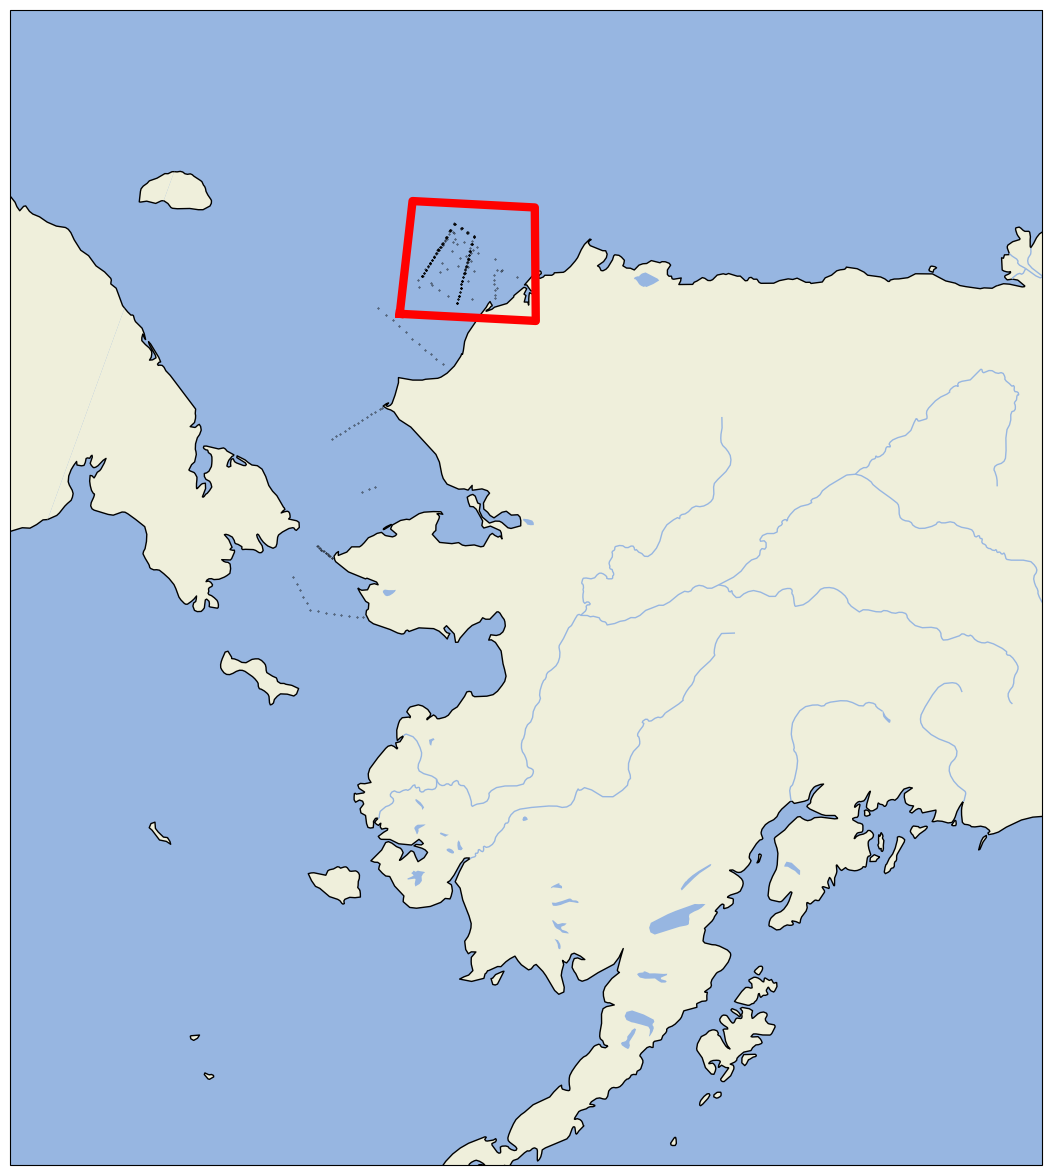

In [307]:
### Context Map

plt.figure(figsize=(15.,15.))

ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude=-160))
extent = [-175, -145, 55, 75]
ax.set_extent(extent, ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES) #, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
# ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.25, linestyle='--', draw_labels=True)


# plot region of subplot
# ax.plot([-175, -165, -155, -185, -175], [65, 65, 72.5, 72.5, 65],
ax.plot([-166.5, -159.5, -159.5, -166.5, -166.5], [70, 70, 72, 72, 70],
         color='red', linewidth=6, marker='.',
         transform=ccrs.PlateCarree(), #remove this line to get straight lines
         )

# bathymetry
# contour = ax.contourf(bathy['x'], bathy['y'], bathy['z'], cmap='Blues', 
#                       levels=15, vmin = 0, vmax = 150, transform=ccrs.PlateCarree())
# contour_lines = ax.contour(bathy['x'], bathy['y'], bathy['z'], levels=contour.levels, colors='black',
#                             linewidths=0.5, transform=ccrs.PlateCarree())
# plt.clabel(contour_lines, fmt='%1.1f', inline=True, fontsize=12)

# stations on track
plt.scatter(stations['Lon'], stations['Lat'], color = 'black', s = 0.1, transform = ccrs.PlateCarree())

# cruise track
#plt.plot(cruise_track['lon'], cruise_track['lat'], color = 'gray', linestyle = '--', transform=ccrs.PlateCarree())

plt.show()

In [308]:
# stations[stations['lap'] == 4]

In [309]:
def extract_parts(s):
    match = re.match(r'^([A-Za-z]{2,3})(\d+)-(\d+)$', s)
    if match:
        return match.groups()
    return None

stations[['section', 'sectionRepeat', 'sectionStation']] = stations['Section Name'].apply(lambda x: pd.Series(extract_parts(x)))

hr = stations[stations['section']=='HR']
hre = stations[stations['section']=='HRE']

hr_ends = hr[hr['Lat'].isin([np.max(hr['Lat']), np.min(hr['Lat'])])]
# hr_ends = pd.concat([hr[hr['Lon'] == hr['Lon'].min()], hr[hr['Lat'] == hr['Lat'].min()]])
hre_ends = hre[hre['Lat'].isin([np.max(hre['Lat']), np.min(hre['Lat'])])]

/var/folders/8g/k7dpf2yx1v31sdbm639f5tc00000gn/T/ipykernel_23423/3185500522.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stations[['section', 'sectionRepeat', 'sectionStation']] = stations['Section Name'].apply(lambda x: pd.Series(extract_parts(x)))
/var/folders/8g/k7dpf2yx1v31sdbm639f5tc00000gn/T/ipykernel_23423/3185500522.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stations[['section', 'sectionRepeat', 'sectionStation']] = stations['Section Name'].apply(lambda x: pd.Series(extract_parts(x)))
/var/folders/8g/k7dpf2yx1v31sdbm639f5tc00000gn/T/ipykernel_23423/3185500522.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  station

In [310]:
hr_ends

,StationCast,Section Name,Lat,Lon,Date,Time,Bottom Depth,section,sectionRepeat,sectionStation
39,S037C01,HR2-9,71.6752,-164.026,20230627,716,38,HR,2,9
176,S171C01,HR6-1,70.6978,-165.525,20230717,1426,43,HR,6,1


In [311]:
## add in velocity vectors
# import pandas as pd
velocity_data = pd.read_csv('../data/ADCP_vector_data/interp_uv_0_100_av_jie_mass_balance.dat', delim_whitespace=True, header=None)
# velocity_data.columns = ['lon', 'lat', 'u', 'v']
velocity_data.columns = ['lon', 'lat', 'u', 'v']
velocity_data['u_deg_sec'] = velocity_data['u'] * (1e-5) / (111 * np.cos(np.deg2rad(velocity_data['lat']))) # 1 cm = 10^-5 km, degree = 111 km * cos(latitude)
velocity_data['v_deg_sec'] = velocity_data['v'] * (1e-5) / 111 # 1 cm = 10^-5 km, degree = 111 km
# velocity_data

# Bob velocity data uses slightly different station positions than I did for HR and HRE Lines
# Within 1km margin, but the sligth offset makes the lines look weird
# reset the ends of HR and HRE lines to match velocity data
northernmost_point = velocity_data.loc[velocity_data['lat'].idxmax()]
westernmost_point = velocity_data.loc[velocity_data['lon'].idxmin()]
southernmost_point = velocity_data.loc[velocity_data['lat'].idxmin()]
easternmost_point = velocity_data.loc[velocity_data['lon'].idxmax()]

# HR connects northernmost and westernmost points
hr_ends = pd.concat([northernmost_point.to_frame().T, westernmost_point.to_frame().T], ignore_index=True)

# HRE connects southernmost and easternmost points
hre_ends = pd.concat([southernmost_point.to_frame().T, easternmost_point.to_frame().T], ignore_index=True)

# print("hr_ends (northernmost and westernmost points):")
# print(hr_ends)
# print("\nhre_ends (southernmost and easternmost points):")
# print(hre_ends)

In [ ]:
# ice_class_colors = {'ow': '#F21A00', 'miz': '#FFA500', 'ice': '#FFFF00'} # red orange yellow
# ice_class_colors = {'ow': 'red', 'miz': 'orange', 'ice': 'yellow'}
# ice_class_colors = {'ow': '#F21A00', 'miz': '#EBCC2A', 'ice': '#3B9AB2'} # red yellow blue
# ice_class_colors = {'ice': "#EBCC2A", 'miz': "#E1AF00", 'ow': "#F21A00"}
# ice_class_colors = {True:"#EBCC2A", False:"#F21A00"}


# ice_class_colors = {'ow': '#3B9AB2', 'miz': '#EBCC2A', 'ice': '#F21A00'} # blue yellow red
# ice_class_colors = {'ow': '#437F97', 'miz': '#688E26', 'ice': '#FFA630'} # cerulean avocado orange peel
# ice_class_colors = {'ow': '#5AAFE9', 'miz': '#A6D948', 'ice': '#FFD776'} # Brighter cerulean avocado orange peel
# ice_class_colors = {'ow': '#9932CC', 'miz': '#FFA500', 'ice': '#228B22'} # purple orange green
# ice_class_colors = {'ow': '#3B65A0', 'miz': '#F4D35E', 'ice': '#A23232'} # blue gold red
# ice_class_colors = {'ow': '#016895', 'miz': '#FFBB00', 'ice': '#b1040e'} # 

In [318]:
ice_class_colors = {'ow': "#44C7FF", 'miz': "#FCCE50", 'ice': "#d63a41"}
t010_color = '#44C7FF'

hr_color = "#2d981d"
# hre_color = "#de9f5c"
hre_color = "#00098C"


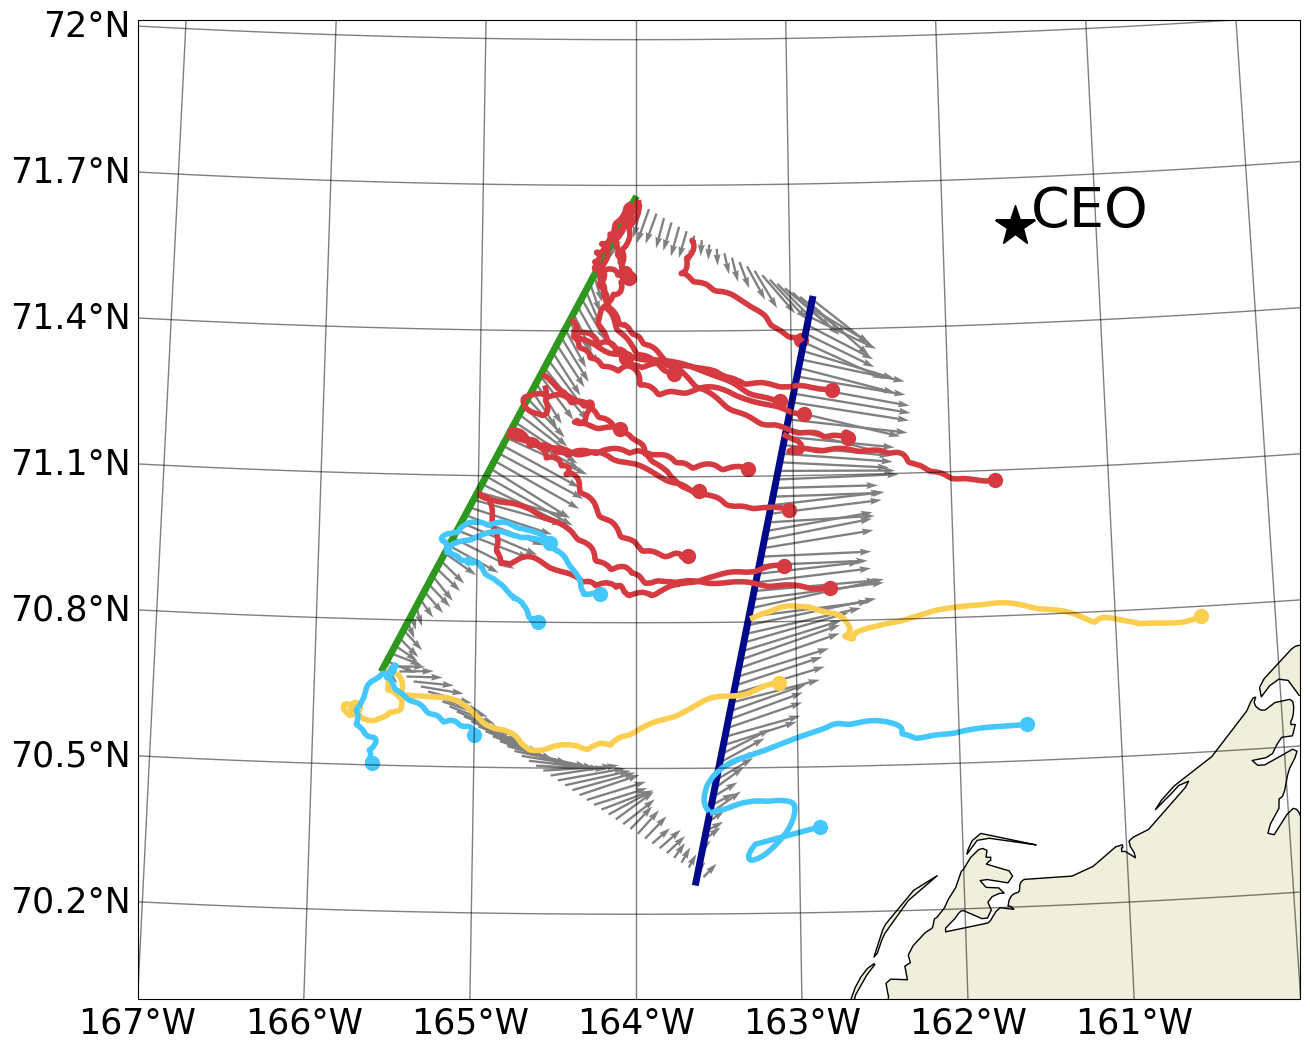

In [320]:
## This actually plots deployments
plt.figure(figsize=(15.,15.), facecolor='none')

plt.rcParams['font.size'] = 25

# ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude=-170))
# extent = [-166, -160, 70.25, 71.75]
ax = plt.axes(projection = ccrs.Orthographic(central_latitude=71, central_longitude=-164))
# ax = plt.axes(projection = ccrs.PlateCarree())
extent = [-167, -160, 70, 72]
ax.set_extent(extent, ccrs.PlateCarree())

# gridlines
gl = ax.gridlines(axes = ax, crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, #linestyle='--',
                  draw_labels=True, x_inline=False, y_inline=False)
# gl.xlabel_style = {'rotation': 30}
gl.ylabel_style = {'rotation': 0}
gl.bottom_labels = True
gl.left_labels   = True
gl.top_labels    = False
gl.right_labels  = False


# ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

# bathymetry
# contour = ax.contourf(bathy['x'], bathy['y'], bathy['z'], cmap='Blues', 
#                       levels=15, vmin = 0, vmax = 150, transform=ccrs.PlateCarree())
# contour_lines = ax.contour(bathy['x'], bathy['y'], bathy['z'], levels=contour.levels, colors='black',
#                             linewidths=0.5, transform=ccrs.PlateCarree())
# plt.clabel(contour_lines, fmt='%1.1f', inline=True, fontsize=12)

# plot HR and HRE lines
ax.plot(hr_ends['lon'], hr_ends['lat'], color = hr_color, transform=ccrs.PlateCarree(), linewidth=5)
ax.plot(hre_ends['lon'], hre_ends['lat'], color = hre_color, transform=ccrs.PlateCarree(), linewidth=5)

# # plot CN
# plt.plot([hr_ends['Lon'].iloc[0], hre_ends['Lon'].iloc[1]],
#          [hr_ends['Lat'].iloc[0], hre_ends['Lat'].iloc[1]],
#          color = 'gray', transform=ccrs.PlateCarree(),
#          linewidth=3)

# # Plot CS
# plt.plot([hr_ends['Lon'].iloc[1], hre_ends['Lon'].iloc[0]],
#          [hr_ends['Lat'].iloc[1], hre_ends['Lat'].iloc[0]],
#          color = 'gray', transform=ccrs.PlateCarree(),
#          linewidth=3)

# Velocity Vectors
ax.quiver(velocity_data['lon'], velocity_data['lat'],
           velocity_data['u_deg_sec'], velocity_data['v_deg_sec'],
           width=0.002,
           color='gray', alpha = 1, scale=0.00005,
           transform=ccrs.PlateCarree())



# full lines of complete deployments
for i in range(len(full_deployments)):

    ice_class = full_deployments[i]['ice_class'].iloc[0]
    # ice_class = full_deployments[i]['iceTethered'].iloc[0]

    plot = ax.plot(full_deployments[i]['longitude'],
             full_deployments[i]['latitude'],
            #  color = 'darkgreen',
             color = ice_class_colors.get(ice_class, 'gray'),
             linewidth = 4,
            #  alpha = 0.5,
             transform=ccrs.PlateCarree())
    
    ax.scatter(full_deployments[i]['longitude'].iloc[0],
             full_deployments[i]['latitude'].iloc[0],
            #  color = 'darkgreen',
             color = ice_class_colors.get(ice_class, 'gray'),
             s=100,
             transform=ccrs.PlateCarree())

# Plotting in T010 spotter data
ax.plot(t010_spotter['Longitude (deg)'],
         t010_spotter['Latitude (deg)'],
         linewidth = 4,
        #  alpha = 0.5,
        #  color = '#F21A00',
        #  color = '#9932CC',
        color = t010_color,
         transform=ccrs.PlateCarree())
ax.scatter(t010_spotter['Longitude (deg)'].iloc[0],
         t010_spotter['Latitude (deg)'].iloc[0],
         s=100,
         # color = '#F21A00',
         #  color = '#9932CC',
         color = t010_color,
         transform=ccrs.PlateCarree())

## Plot in CEO Observatory at (71º 35.976’ N, 161º 31.621’ W), (71.5996 N, -161.5270 W)
ax.plot(-161.5270, 71.5996, marker='*', color='black', markersize=30, transform=ccrs.PlateCarree())
ax.text(-161.5270 + 0.1, 71.5996, 'CEO', color='black', fontsize=40, transform=ccrs.PlateCarree())

# Plot in the NECS Benthic Hotspot Proposed by Grebmeier et al 2015
# NECS (Northeast Chukchi Sea), 70.62°N–72.37°N, 158.46°W–165.46°W.
## Decimal Degrees: [70.62, 72.37] N, [-165.46, -158.46] E
# plt.plot([-165.46, -165.46, -158.46, -158.46, -165.46],
#         [70.62, 72.37, 72.37, 70.62, 70.62],
#         linewidth = 4,
#         color = 'goldenrod',
#         transform=ccrs.PlateCarree())


# cruise track
# plt.plot(cruise_track['lon'], cruise_track['lat'], color = 'gray', alpha = 0.5, linestyle = '--', transform=ccrs.PlateCarree())

plt.savefig('../plot/all_deployments_with_velocityVectors.png', bbox_inches='tight', transparent=True)

plt.show()